In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your ZIP file in Drive (change this if needed)
zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/dataset'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Optional: Check folders
for root, dirs, files in os.walk(extract_path):
    print(root)


Mounted at /content/drive
/content/dataset
/content/dataset/RetinalOCT_Dataset
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/CSR
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/NORMAL
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/DRUSEN
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/DME
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/AMD
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/DR
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/CNV
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test/MH
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/train
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/train/CSR
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/train/NORMAL
/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/train/DRUSEN
/content/dataset/RetinalOCT_

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/train'
test_dir = '/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test'

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 16560 images belonging to 8 classes.
Found 1840 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

def identity_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def conv_block(x, filters):
    shortcut = layers.Conv2D(filters, (1, 1), strides=2, padding='same')(x)

    x = layers.Conv2D(filters, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_optimized_model(input_shape=(224, 224, 3), num_classes=8):
    inputs = tf.keras.Input(shape=input_shape)

    # Stage 1
    x = layers.Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Stage 2 - Branch 1
    b1 = conv_block(x, 64)
    b1 = identity_block(b1, 64)
    b1 = identity_block(b1, 64)
    b1 = conv_block(b1, 128)
    b1 = identity_block(b1, 128)
    b1 = identity_block(b1, 128)
    b1 = layers.GlobalAveragePooling2D()(b1)

    # Stage 2 - Branch 2
    b2 = conv_block(x, 64)
    b2 = identity_block(b2, 64)
    b2 = identity_block(b2, 64)
    b2 = layers.GlobalAveragePooling2D()(b2)

    # Stage 3 - Fusion and Classification
    merged = layers.Concatenate()([b1, b2])
    x = layers.Flatten()(merged)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

model = build_optimized_model(num_classes=train_data.num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_5[0][0]  

 Total params: 1,271,752 (4.85 MB)

 Trainable params: 1,268,360 (4.84 MB)

 Non-trainable params: 3,392 (13.25 KB)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # slower but more stable
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint("retinal_c8_best_model.h5", save_best_only=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=22,         # give model more time
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4765 - loss: 1.2196

518/518 ━━━━━━━━━━━━━━━━━━━━ 293s 516ms/step - accuracy: 0.4767 - loss: 1.2191 - val_accuracy: 0.2370 - val_loss: 4.1381 - learning_rate: 5.0000e-04
Epoch 2/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7507 - loss: 0.6487

518/518 ━━━━━━━━━━━━━━━━━━━━ 253s 489ms/step - accuracy: 0.7508 - loss: 0.6485 - val_accuracy: 0.5723 - val_loss: 1.6424 - learning_rate: 5.0000e-04
Epoch 3/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8144 - loss: 0.4902

518/518 ━━━━━━━━━━━━━━━━━━━━ 260s 501ms/step - accuracy: 0.8144 - loss: 0.4902 - val_accuracy: 0.7728 - val_loss: 0.5951 - learning_rate: 5.0000e-04
Epoch 4/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 256s 493ms/step - accuracy: 0.8553 - loss: 0.4066 - val_accuracy: 0.5891 - val_loss: 1.2791 - learning_rate: 5.0000e-04
Epoch 5/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8725 - loss: 0.3523

518/518 ━━━━━━━━━━━━━━━━━━━━ 259s 499ms/step - accuracy: 0.8725 - loss: 0.3523 - val_accuracy: 0.8266 - val_loss: 0.4480 - learning_rate: 5.0000e-04
Epoch 6/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 254s 491ms/step - accuracy: 0.8824 - loss: 0.3118 - val_accuracy: 0.8141 - val_loss: 0.5160 - learning_rate: 5.0000e-04
Epoch 7/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9011 - loss: 0.2717
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
518/518 ━━━━━━━━━━━━━━━━━━━━ 261s 489ms/step - accuracy: 0.9011 - loss: 0.2717 - val_accuracy: 0.6391 - val_loss: 1.4273 - learning_rate: 5.0000e-04
Epoch 8/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9272 - loss: 0.2088

518/518 ━━━━━━━━━━━━━━━━━━━━ 254s 489ms/step - accuracy: 0.9273 - loss: 0.2088 - val_accuracy: 0.9005 - val_loss: 0.2512 - learning_rate: 2.5000e-04
Epoch 9/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 253s 488ms/step - accuracy: 0.9361 - loss: 0.1850 - val_accuracy: 0.8924 - val_loss: 0.3045 - learning_rate: 2.5000e-04
Epoch 10/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9385 - loss: 0.1794

518/518 ━━━━━━━━━━━━━━━━━━━━ 254s 491ms/step - accuracy: 0.9385 - loss: 0.1794 - val_accuracy: 0.9141 - val_loss: 0.2380 - learning_rate: 2.5000e-04
Epoch 11/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 254s 489ms/step - accuracy: 0.9422 - loss: 0.1693 - val_accuracy: 0.9000 - val_loss: 0.2845 - learning_rate: 2.5000e-04
Epoch 12/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9471 - loss: 0.1590
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
518/518 ━━━━━━━━━━━━━━━━━━━━ 257s 497ms/step - accuracy: 0.9471 - loss: 0.1591 - val_accuracy: 0.9152 - val_loss: 0.2670 - learning_rate: 2.5000e-04
Epoch 13/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9528 - loss: 0.1422

518/518 ━━━━━━━━━━━━━━━━━━━━ 254s 490ms/step - accuracy: 0.9528 - loss: 0.1422 - val_accuracy: 0.9413 - val_loss: 0.1623 - learning_rate: 1.2500e-04
Epoch 14/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9577 - loss: 0.1231

518/518 ━━━━━━━━━━━━━━━━━━━━ 254s 491ms/step - accuracy: 0.9577 - loss: 0.1231 - val_accuracy: 0.9495 - val_loss: 0.1409 - learning_rate: 1.2500e-04
Epoch 15/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 255s 493ms/step - accuracy: 0.9629 - loss: 0.1155 - val_accuracy: 0.9533 - val_loss: 0.1542 - learning_rate: 1.2500e-04
Epoch 16/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9562 - loss: 0.1222
Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
518/518 ━━━━━━━━━━━━━━━━━━━━ 252s 487ms/step - accuracy: 0.9562 - loss: 0.1222 - val_accuracy: 0.9190 - val_loss: 0.2682 - learning_rate: 1.2500e-04
Epoch 17/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9682 - loss: 0.0969

518/518 ━━━━━━━━━━━━━━━━━━━━ 256s 494ms/step - accuracy: 0.9682 - loss: 0.0969 - val_accuracy: 0.9587 - val_loss: 0.1264 - learning_rate: 6.2500e-05
Epoch 18/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 250s 482ms/step - accuracy: 0.9679 - loss: 0.0962 - val_accuracy: 0.9380 - val_loss: 0.1867 - learning_rate: 6.2500e-05
Epoch 19/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9690 - loss: 0.0923
Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
518/518 ━━━━━━━━━━━━━━━━━━━━ 251s 485ms/step - accuracy: 0.9689 - loss: 0.0923 - val_accuracy: 0.9543 - val_loss: 0.1433 - learning_rate: 6.2500e-05
Epoch 20/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 249s 480ms/step - accuracy: 0.9715 - loss: 0.0907 - val_accuracy: 0.9500 - val_loss: 0.1454 - learning_rate: 3.1250e-05
Epoch 21/22
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9697 - loss: 0.0899
Epoch 21: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
518/518 ━━━━━━━━━━━━━━━━━━━━ 281s 542ms/step - 

In [6]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predict on test set
Y_pred = model.predict(test_data)
y_pred = Y_pred.argmax(axis=1)
y_true = test_data.classes

# Print metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1 Score:", f1_score(y_true, y_pred, average='macro'))


88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step
Accuracy: 0.9507142857142857
Precision: 0.9524095532122494
Recall: 0.9507142857142857
F1 Score: 0.9506646401551344


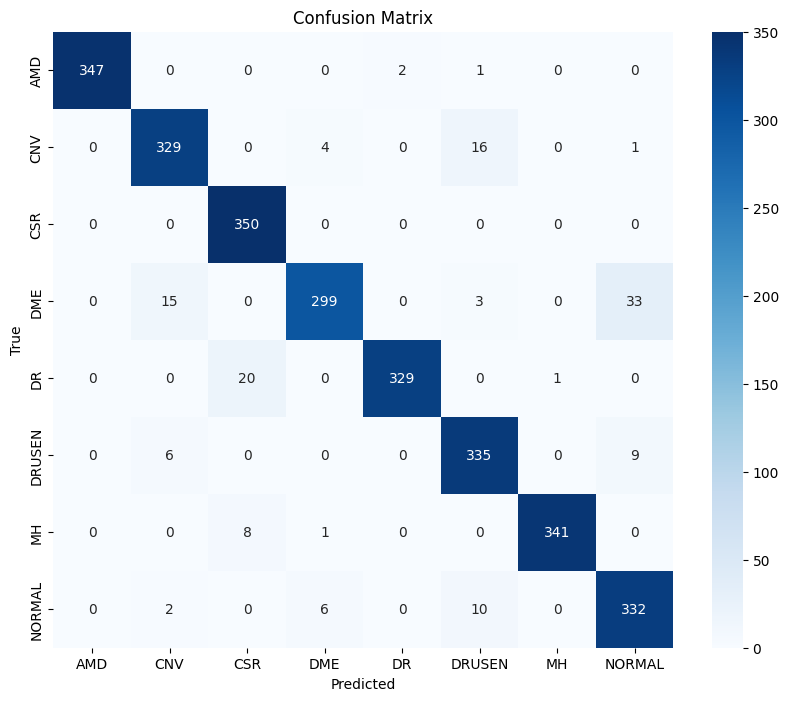

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


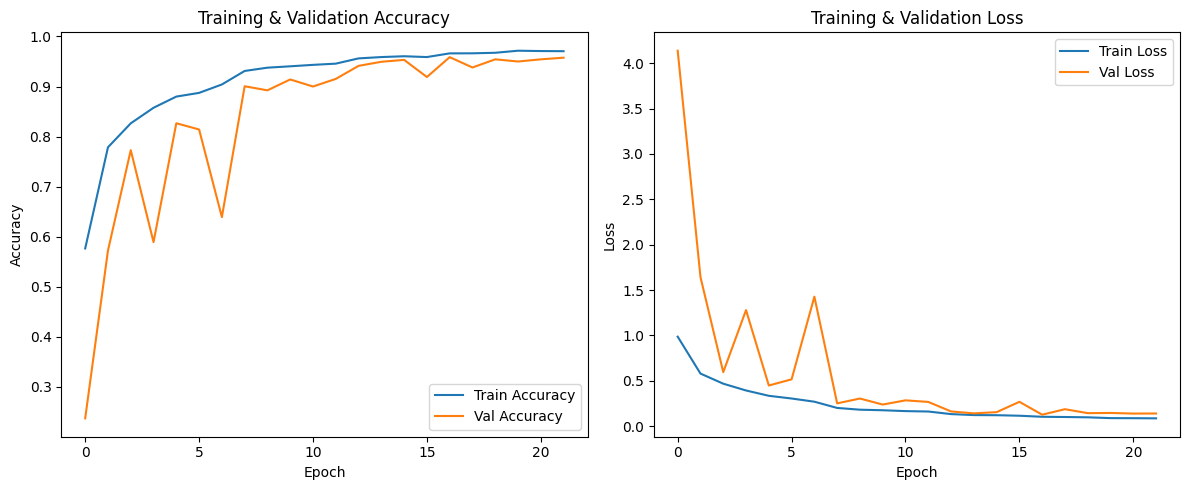

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [9]:
from google.colab import files
uploaded = files.upload()


Saving amd_test_1001.jpg to amd_test_1001.jpg


In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: AMD
Confidence: 1.00


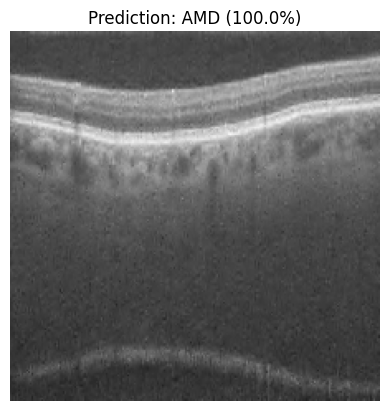

In [11]:
from tensorflow.keras.models import load_model

model = load_model('retinal_c8_best_model.h5')  # Load best model if not already loaded
pred = model.predict(img_array)
pred_class = np.argmax(pred)
confidence = np.max(pred)

class_labels = list(train_data.class_indices.keys())

print(f"Predicted class: {class_labels[pred_class]}")
print(f"Confidence: {confidence:.2f}")

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_labels[pred_class]} ({confidence*100:.1f}%)")
plt.show()


In [12]:
model.save('retinal_c8_model.h5')


In [13]:
from google.colab import files
files.download('retinal_c8_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

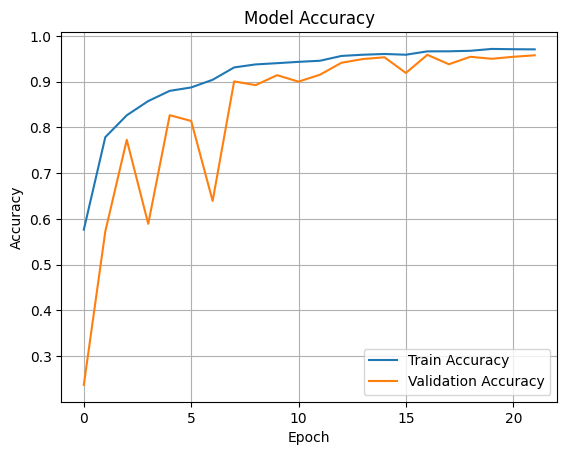

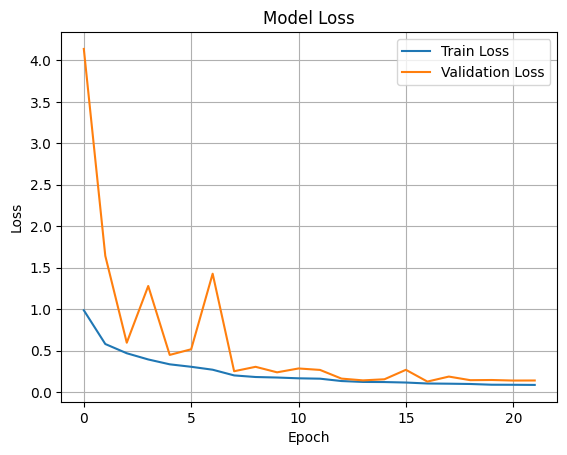

In [14]:
# Step 5: Plot Accuracy and Loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step


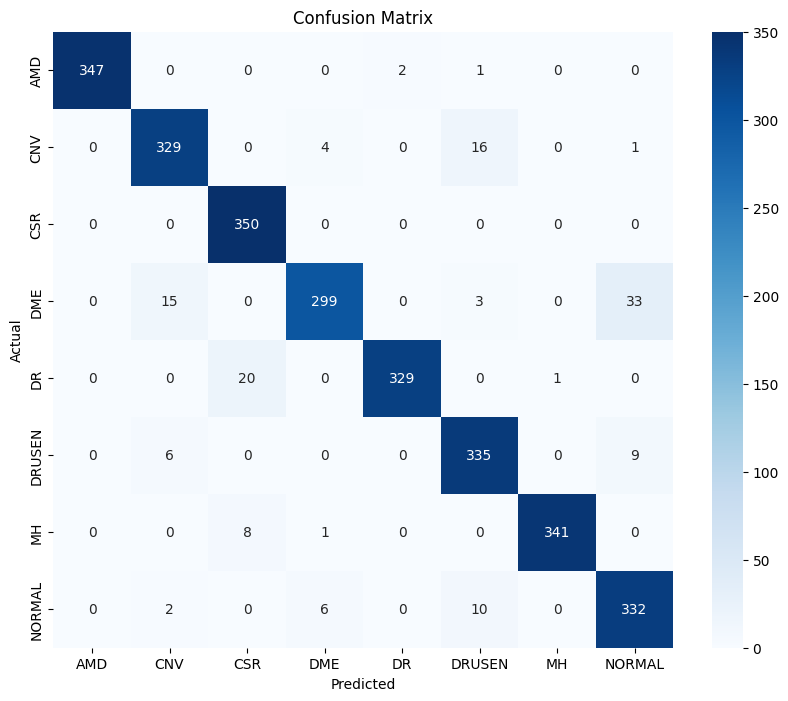

Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      0.99      1.00       350
         CNV       0.93      0.94      0.94       350
         CSR       0.93      1.00      0.96       350
         DME       0.96      0.85      0.91       350
          DR       0.99      0.94      0.97       350
      DRUSEN       0.92      0.96      0.94       350
          MH       1.00      0.97      0.99       350
      NORMAL       0.89      0.95      0.92       350

    accuracy                           0.95      2800
   macro avg       0.95      0.95      0.95      2800
weighted avg       0.95      0.95      0.95      2800



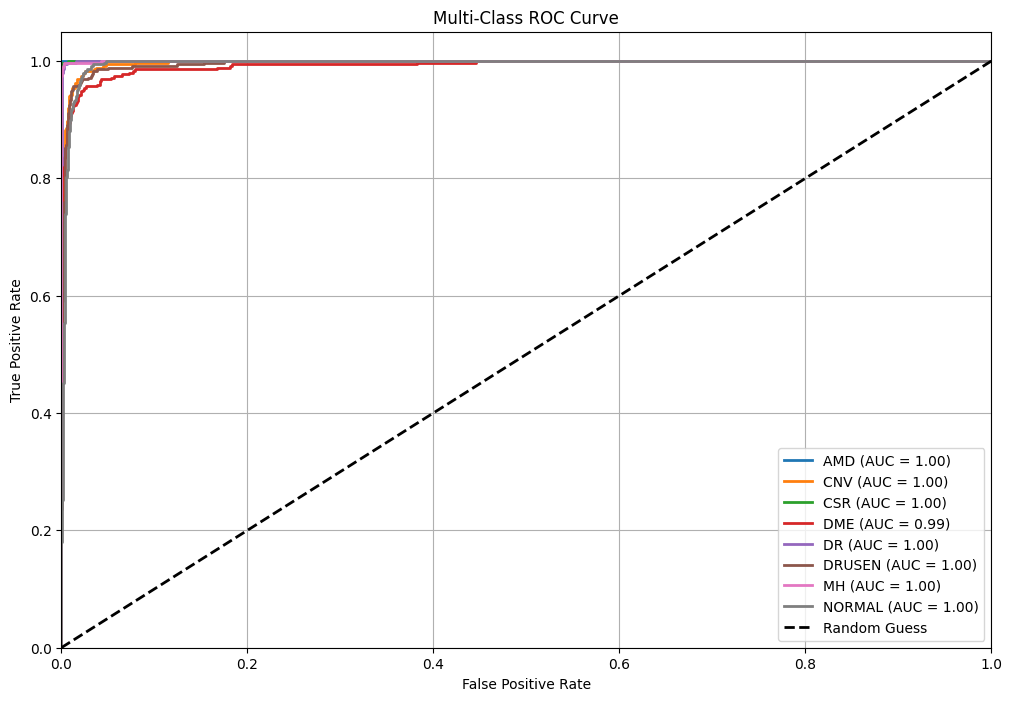

In [15]:
# Step 6: Final Evaluation (Confusion Matrix, Classification Report, ROC Curve)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Predict on test set
preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 4. ROC Curve and AUC for Multi-Class
# Convert labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_labels)

plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


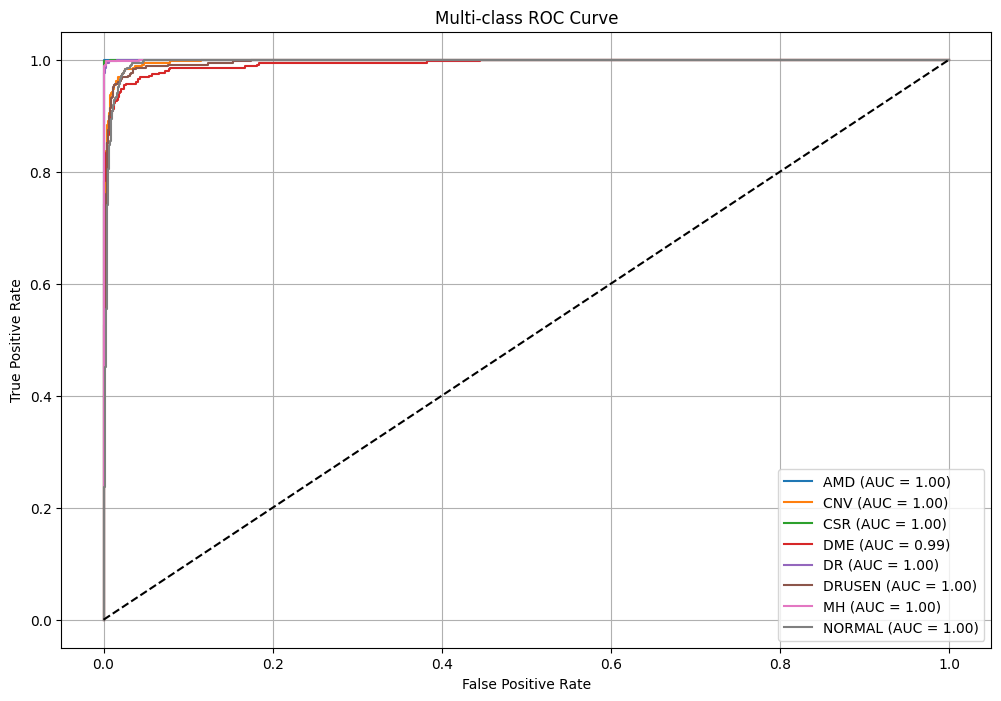

In [16]:
# Step 7: Optional ROC Curve (per class)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Saving csr_test_1001.jpg to csr_test_1001.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: CSR
Confidence: 1.00


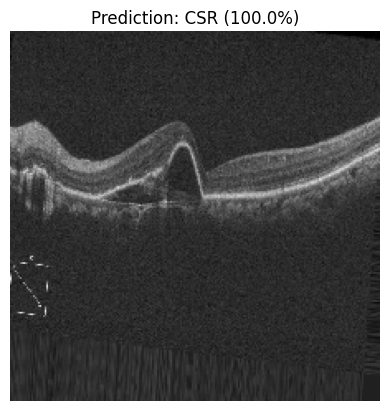

conv2d
conv2d_2
conv2d_3
conv2d_1
conv2d_4
conv2d_5
conv2d_6
conv2d_7
conv2d_9
conv2d_16
conv2d_10
conv2d_17
conv2d_8
conv2d_15
conv2d_11
conv2d_18
conv2d_12
conv2d_19
conv2d_13
conv2d_20
conv2d_14
conv2d_21


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


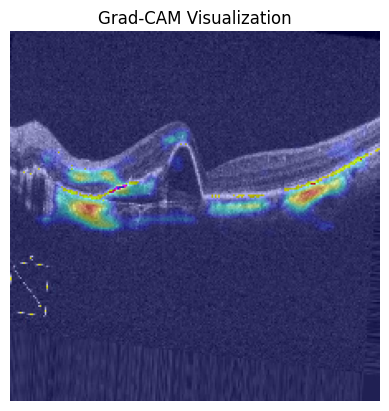

In [18]:
# Step 8: Single Image Inference + Grad-CAM
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

# === Upload Image ===
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array_exp = np.expand_dims(img_array, axis=0) / 255.0

# === Load Model ===
model = load_model('retinal_c8_best_model.h5')

# === Predict ===
pred = model.predict(img_array_exp)
pred_class = np.argmax(pred)
confidence = np.max(pred)

# === Class Labels (update if needed) ===
class_labels = list(test_data.class_indices.keys())  # Uses your loaded dataset's class mapping

print(f"Predicted class: {class_labels[pred_class]}")
print(f"Confidence: {confidence:.2f}")

# === Display Uploaded Image ===
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_labels[pred_class]} ({confidence*100:.1f}%)")
plt.show()

# === Grad-CAM Utility Functions ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_array, heatmap, alpha=0.4):
    img = image_array.astype(np.uint8)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    return cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB)

# === Choose last conv layer (check your model if unsure) ===
for layer in model.layers:
    if 'conv' in layer.name:
        print(layer.name)

# Use the last printed conv layer name here:
last_conv_layer_name = 'conv2d_7'  # Replace with actual layer if needed

# === Generate and Display Grad-CAM ===
heatmap = make_gradcam_heatmap(img_array_exp, model, last_conv_layer_name, pred_class)
gradcam_img = display_gradcam(img_array, heatmap)

plt.imshow(gradcam_img)
plt.axis('off')
plt.title('Grad-CAM Visualization')
plt.show()


In [28]:
from fpdf import FPDF
import os
from datetime import datetime

# === Ask for Patient Details ===
print("\n--- Enter Patient Details ---")
patient_id = input("Patient ID: ")
age = input("Age: ")
gender = input("Gender (M/F): ")
notes = input("Additional Notes (optional): ")

# === Save images ===
original_path = "original_image.jpg"
gradcam_path = "gradcam_image.jpg"
plt.imsave(original_path, img_array.astype(np.uint8))
plt.imsave(gradcam_path, gradcam_img)

# === PDF Report with Side-by-Side Images ===
pdf = FPDF()
pdf.set_auto_page_break(auto=False, margin=5)
pdf.add_page()

# --- Title ---
pdf.set_font("Arial", 'B', 14)
pdf.cell(190, 8, "Retinal Disease Prediction Report", ln=True, align='C')

# --- Metadata & Patient Info ---
pdf.set_font("Arial", '', 10)
pdf.cell(190, 5, f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", ln=True)
pdf.cell(190, 5, f"Patient ID: {patient_id}", ln=True)
pdf.cell(190, 5, f"Age: {age}    Gender: {gender}", ln=True)
pdf.multi_cell(0, 5, f"Notes: {notes}", align="L")

# --- Prediction ---
pdf.cell(190, 5, f"Prediction: {class_labels[pred_class]}", ln=True)
pdf.cell(190, 5, f"Confidence: {confidence*100:.2f}%", ln=True)

# --- Images ---
pdf.set_font("Arial", 'B', 10)
pdf.ln(2)
pdf.cell(95, 5, "Original Image", ln=False, align='C')
pdf.cell(95, 5, "Grad-CAM Visualization", ln=True, align='C')

# Place both images side-by-side at same Y level
x1, x2, y = 10, 105, pdf.get_y() + 3
pdf.image(original_path, x=x1, y=y, w=85)
pdf.image(gradcam_path, x=x2, y=y, w=85)

# === Save and download ===
report_filename = f"Patient_{patient_id}_Report.pdf"
pdf.output(report_filename)
files.download(report_filename)



--- Enter Patient Details ---
Patient ID: 20
Age: 20
Gender (M/F): m
Additional Notes (optional): nothing


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=44e6dab6511cd8ba734d104daddb8e1fa9cf09e70da383c95ec06e9ab5c4fed3
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
